## Data pull, parsing and preliminary modeling
#### CS109a - Sam, Luke, Jake, Jeremy
#### Chicago Food Inspection Forecasting
#### Last Updated: 11/28/16

In [2]:
#!/usr/bin/env python
"""
Download the data required for the data science 109 project
for Sam, Luke, Jake, and Jeremy's group.
"""

import datetime
import optparse
import requests
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from sys import exit
import math
import matplotlib.pyplot as plt
%matplotlib inline



SOCRATA_TOKEN='jWNb7dvQQlhOyTJPutAIGJheR'

INSPECTION_ENDPOINT = 'https://data.cityofchicago.org/resource/cwig-ma7x.json'
BUSINESS_ENDPOINT = 'https://data.cityofchicago.org/resource/xqx5-8hwx.json'
CRIME_ENDPOINT = 'https://data.cityofchicago.org/resource/6zsd-86xi.json'
SANITATION_ENDPOINT = 'https://data.cityofchicago.org/resource/kcdz-f29q.json'

def make_request(url, auth=SOCRATA_TOKEN):
    """
    Issue a token-authed request to the required URL.
    """
    if auth is SOCRATA_TOKEN:
        return requests.get(url, headers={'X-App-Token': SOCRATA_TOKEN})
    elif auth is NOAA_TOKEN:
        return requests.get(url, headers={'token': NOAA_TOKEN})

# def build_weather_query(location_zip, start, end):
#     """
#     Build the query URL for the inspections data. 
#     """

#     return "{}&locationid=ZIP:{}&startdate={}&enddate={}".format(NOAA_BASE, location_zip, start.isoformat(), end.isoformat())

def build_inspection_query(start):
    """
    Given an inspection date, build a query for all of the inspections
    occuring on or after that day.
    """
    return "{}?$where=inspection_date>='{}'&$limit=10000000".format(INSPECTION_ENDPOINT, start.isoformat())

def build_crime_query(start):
    """
    Build the URL query to retrieve crime data.
    """
    return "{}?$where=date>='{}'&$limit=10000000".format(CRIME_ENDPOINT, start.isoformat())

def build_business_query(ids):
    """
    Build the URL query for the license numbers
    """
    # in_set = ", ".join([repr(str(i)) for i in biz_ids])
    return "{}?$where=license_number in({})&$limit=10000000".format(BUSINESS_ENDPOINT, ', '.join(["'{}'".format(i) for i in ids]))

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

def get_business_data(ids):
    """
    Retrieve business license record data for all of the ids in ids
    batching requests as appropriate (can request ~30 at a time)
    """
    urls = [build_business_query(id_chunk) for id_chunk in chunks(ids, 300)]

    json_data = []
    for url in urls:
        try:
            try:
                data = make_request(url).json()
                json_data.extend(data)
                print "Succeeded!"
            except requests.HTTPError as e:
                print e
                continue
        except Exception as e:
            print e
            print type(data)
            continue

    return json_data

def build_sanitation_query(start):
    """
    Build the query URL for sanitation data in the period of interest
    """
    return "{}?$where=creation_date>='{}'&$limit=10000000".format(SANITATION_ENDPOINT, start.isoformat())

def get_loc(row):
    return row['latitude'], row['longitude']

def distance(d1, d2):
    lat1, lon1 = d1
    lat2, lon2 = d2
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

def count_incidents_nearby(row, incident_df, num_days = 5, max_dist=5):
    def get_loc(r):
        return r['latitude'], r['longitude']

    d1 = get_loc(row)
    
    def keep(d):
        recent = abs((d['creation_date'] - row['inspection_date']).days) < num_days
        before = abs((d['creation_date'] - row['inspection_date']).days) >= 0
        return (recent and before)
    
    last_n_days = incident_df.apply(lambda d: keep(d),axis=1 )
    valid =incident_df[last_n_days]
    
    if len(valid) < 1:
        return 0
    
    dists = valid.apply(lambda r: distance(d1, get_loc(r)), axis=1) < max_dist
    
    return len(valid[dists])

def count_crimes_nearby(row, incident_df, num_days = 5, max_dist=5):
    def get_loc(r):
        return r['latitude'], r['longitude']

    d1 = get_loc(row)
    
    def keep(d):
        recent = abs((d['date'] - row['inspection_date']).days) < num_days
        before = abs((d['date'] - row['inspection_date']).days) >= 0
        return (recent and before)
    
    last_n_days = incident_df.apply(lambda d: keep(d),axis=1 )
    valid =incident_df[last_n_days]
    
    if len(valid) < 1:
        return 0
    
    dists = valid.apply(lambda r: distance(d1, get_loc(r)), axis=1) < max_dist
    
    return len(valid[dists])

def filter_sanitation_police(df):
    idate = df['inspection_date']
    cdate = df['creation_date']
    
    before = cdate < idate
    import datetime
    after = abs(cdate - idate) < datetime.timedelta(days=5)
    
    return df[before & after]

def filter_crime_by_police(df):
    idate = df['date']
    cdate = df['creation_date']
    
    before = cdate < idate
    import datetime
    after = abs(cdate - idate) < datetime.timedelta(days=5)
    
    ret = df[before & after].copy()
    del ret['date']
    return ret

def main(date=datetime.datetime.today(),export=True):
    """
    Runner function.
    """
    start_date = date
    
    print "Fetching data beginning {}.".format(start_date.date())

    insp_req = build_inspection_query(start_date)

    try:
        inspection_data = make_request(insp_req).json()
    except requests.HTTPError as excep:
        print excep
        print "Inspection data retrieval failed."
        exit(1)

    if len(inspection_data) < 1:
        print "No inspection data received."
        exit(1)
    else:
        print "{} records received. Finding businesses...".format(len(inspection_data))

    ids = list(set([str(d.get('license_')) for d in inspection_data]))

    business_data = get_business_data(ids)

    print "RECEIVED {} business details".format(len(business_data))
    
    
    inspection_df = pd.DataFrame(inspection_data).loc[:, [u'dba_name',
                                                          u'facility_type',
                                                          u'inspection_date',
                                                          u'inspection_type',
                                                          u'inspection_id',
                                                          u'violations',
                                                          u'latitude',
                                                          u'license_',
                                                          u'longitude',
                                                          u'results',
                                                          u'risk',
                                                          u'zip']]
    bad_indices = []
    good_indices = []
    for biz_index in range(len(business_data)):
        biz_dict = business_data[biz_index]
        if type(biz_dict) != type({1: 0}):
            bad_indices.append(biz_index)
        else:
            good_indices.append(biz_index)
    
    
    business_data = list(np.array(business_data)[good_indices])
    


    biz_df = pd.DataFrame(business_data).loc[:, [u'business_activity', u'date_issued', 
                                                 u'latitude', u'license_description',
                                                 u'license_number', u'license_start_date',
                                                 u'license_status', u'longitude',
                                                 u'police_district', u'precinct',
                                                 u'site_number', u'ward_precinct', u'zip_code']]

    #Investigate original business data: business_data
    #Each entry of the list is a unique license entry: businesses have multiple license entries
    #Currently we only pull the most recent
    #We might lose unexpired liquor and tobacco licenses that aren't the most recent
    
    biz_df = biz_df.set_index('license_number')

    biz_df['license_start_date'] = pd.to_datetime(biz_df['license_start_date'])

    biz_df = biz_df.groupby(biz_df.index).apply(lambda g: g[g['license_start_date'] == g['license_start_date'].max()])
    biz_df.index = biz_df.index.droplevel()

    insp_biz_df = inspection_df.join(biz_df, rsuffix='_biz', on='license_')
    
    insp_biz_df['latitude'] = pd.to_numeric(insp_biz_df['latitude'])
    insp_biz_df['longitude'] = pd.to_numeric(insp_biz_df['longitude'])
    insp_biz_df['latitude_biz'] = pd.to_numeric(insp_biz_df['latitude_biz'],errors='coerce')
    insp_biz_df['longitude_biz'] = pd.to_numeric(insp_biz_df['longitude_biz'],errors='coerce')
    insp_biz_df['inspection_date'] = pd.to_datetime(insp_biz_df['inspection_date'])
    

    sanitation_url = build_sanitation_query(start_date)
    try:
        sanitation_data = make_request(sanitation_url).json()
    except requests.HTTPError as excep:
        print crime_url
        print excep
        exit(1)
    print "SANITATION LEN: {}".format(len(sanitation_data))

    sanitation_df = pd.DataFrame(sanitation_data).loc[:, [
                                                     u'creation_date',
                                                     u'police_district',
                                                     u'latitude',
                                                     u'longitude',
                                                     u'zip_code']]
    sanitation_df['latitude'] = pd.to_numeric(sanitation_df['latitude'])
    sanitation_df['longitude'] = pd.to_numeric(sanitation_df['longitude'])
    sanitation_df['creation_date'] = pd.to_datetime(sanitation_df['creation_date'])
    
    

    sanit_df = pd.DataFrame(sanitation_df).groupby(['creation_date','police_district']).count().reset_index().set_index('police_district')
    del sanit_df['latitude']
    del sanit_df['longitude']
    sanit_df.columns.values[1] = 'num_sanitation_in_police_dist'
    sanit_df = sanit_df.reset_index()

    ###
    ### This code works, but is also very slow. Only run it if you find out the dataset has a lot of 
    ### missing values. 
    # insp_biz_df['sanitation_by_location'] = insp_biz_df.apply(lambda r: count_incidents_nearby(r, sanitation_df),axis=1)
    # insp_biz_df = insp_biz_df.join(sanit_df, on=['police_district'])
    insp_biz_df = pd.merge(insp_biz_df, sanit_df, left_on=['inspection_date', 'police_district'], right_on=['creation_date', 'police_district'], how='left')

    crime_url = build_crime_query(start_date)
    try:
        crime_data = make_request(crime_url).json()
    except requests.HTTPError as excep:
        print crime_url
        print excep
        exit(1)
    print "CRIME LEN: {}".format(len(crime_data))

    crime_df = pd.DataFrame(crime_data).loc[:, ['date', 'latitude', 'longitude', 'district']]
    crime_df['date'] = pd.to_datetime(crime_df['date'])
    crime_df['district'] = pd.to_numeric(crime_df['district'])
    crime_df['latitude'] = pd.to_numeric(crime_df['latitude'])
    crime_df['longitude'] = pd.to_numeric(crime_df['longitude'])

    time = pd.DatetimeIndex(crime_df['date'])
    crime_by_district = crime_df.groupby([crime_df['district'],time.date]).count()
    crime_by_district['crime_count_by_district'] = crime_by_district['latitude']
    del crime_by_district['latitude']
    del crime_by_district['longitude']
    del crime_by_district['date']
    del crime_by_district['district']

    crime_by_district = crime_by_district.reset_index()

    crime_by_district['date'] = crime_by_district['level_1']
    del crime_by_district['level_1']
    crime_by_district['date'] = pd.to_datetime(crime_by_district['date'])
    crime_by_district = crime_by_district.reset_index()
    
    
    # the code below generates count for sanitation complaints and crimes based on an arbitary latitude longitude grid
    # counts are then linked to inspections based on the inspection latitude and longitude
    n_long_bins = 7
    n_lat_bins = 10
    yedges = np.linspace(insp_biz_df.longitude.min(),insp_biz_df.longitude.max(),n_long_bins+1)
    xedges = np.linspace(insp_biz_df.latitude.min(),insp_biz_df.latitude.max(),n_lat_bins+1)
    
    x_sanit = sanitation_df['latitude']
    y_sanit = sanitation_df['longitude']
   
    x_crime = crime_df['latitude']
    y_crime = crime_df['longitude']
    
    x_biz = np.array(biz_df['latitude'])
    y_biz = np.array(biz_df['longitude'])   
    
    x = insp_biz_df['latitude']
    y = insp_biz_df['longitude']
    
    sanitation_hist, xedges, yedges = np.histogram2d(x_sanit, y_sanit, (xedges, yedges))
    crime_hist, xedges, yedges = np.histogram2d(x_crime, y_crime, (xedges, yedges))
    
    #biz_hist, xedges, yedges = np.histogram2d(x_biz, y_biz, (xedges, yedges))

    
    xidx = np.clip(np.digitize(x, xedges), 0, sanitation_hist.shape[0]-1)
    yidx = np.clip(np.digitize(y, yedges), 0, sanitation_hist.shape[1]-1)
    
    sanit_count = sanitation_hist[xidx, yidx]
    crime_count = crime_hist[xidx, yidx]
    #biz_count = biz_hist[xidx, yidx]

    
    insp_biz_df['sanit_count'] = sanit_count
    insp_biz_df['crime_count'] = crime_count
    #insp_biz_df['biz_count'] = biz_count


    insp_biz_df['police_district'] = pd.to_numeric(insp_biz_df['police_district'])
    insp_biz_df = pd.merge(insp_biz_df, crime_by_district, left_on=['inspection_date', 'police_district'], right_on=['date', 'district'], how='left')

    ###
    ### This code works, but it's really really fucking slow, so maybe don't run it.
    ###
    #insp_biz_df['crimes_by_location'] = insp_biz_df.apply(lambda r: count_crimes_nearby(r, crime_df),axis=1)
    import os
    if export == True:
        insp_biz_df.to_csv('DOWNLOADED_DATA_1.csv', index=False)
    #inspection_df.to_csv('DOWNLOADED_DATA_2.csv', index=False)
    #biz_df.to_csv('DOWNLOADED_DATA_3.csv', index=False)

    
    # weather_url = build_weather_query('02138', start_date,
    #                                        datetime.datetime.today())
    # print weather_url
    # print make_request(,
    #                    auth=NOAA_TOKEN).json()

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import datetime
import optparse
import requests
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from sys import exit
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
main(date=datetime.datetime.strptime('01/01/2015', '%m/%d/%Y'),export=True)

Fetching data beginning 2015-01-01.
38800 records received. Finding businesses...
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
Succeeded!
RECEIVED 66130 business details
SANITATION LEN: 39380
CRIME LEN: 503788


/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


First we load in the data:

In [5]:
data = pd.read_csv('DOWNLOADED_DATA_1.csv')


Now we check out the columns:

These functions build binary indicators for license types 

In [6]:
def fail(result):
    if 'Fail' in result:
        return 0
    else:
        return 1
    
def tobacco(license_description):
    if 'Tobacco Retail Over Counter' == license_description:
        return 1
    else:
        return 0
    
def liquor(license_description):
    if 'Consumption on Premises - Incidental Activity' == license_description:
        return 1
    else:
        return 0
    
def grocery_store(facility_type):
    if 'Grocery Store' == facility_type:
        return 1
    else:
        return 0

In [7]:
data['result_binary'] = [fail(result) for result in data.results]
data['consumption_license'] = [liquor(license) for license in data.license_description]
data['tobacco'] = [tobacco(license) for license in data.license_description]
data['grocery'] = [grocery_store(facility_type) for facility_type in data.facility_type]

In [8]:
data['inspection_date'] = pd.to_datetime(data['inspection_date'])
data['license_start_date'] = pd.to_datetime(data['license_start_date'])
data['date_issued'] = pd.to_datetime(data['date_issued'])
data['creation_date'] = pd.to_datetime(data['creation_date'])

In [9]:
import re

critical_flags = re.compile(r'(\bCRITICAL\b)',flags = re.IGNORECASE)
serious_flags = re.compile(r'(\bSERIOUS\b)',flags = re.IGNORECASE)
citation_flags = re.compile(r'(\bCITATION\b)',flags = re.IGNORECASE)
violation_flags = re.compile(r'(\bVIOLATION\b)',flags = re.IGNORECASE)
minor_flags = re.compile(r'(\bMINOR\b)',flags = re.IGNORECASE)


In [10]:
violations_count = []
citations_count = []
critical_count = []
serious_count = []
minor_count = []

LOG_EVERY_N = 10000


  
for index in data.index:
    text = data.ix[index].violations
    
    if type(text) == type(' '):
        violations_count.append(violation_flags.subn('',text)[1])
        citations_count.append(citation_flags.subn('',text)[1])
        critical_count.append(critical_flags.subn('',text)[1])
        serious_count.append(serious_flags.subn('',text)[1])
        minor_count.append(minor_flags.subn('',text)[1])

    else:
        violations_count.append(float('nan'))
        citations_count.append(float('nan'))
        critical_count.append(float('nan'))
        serious_count.append(float('nan'))
        minor_count.append(float('nan'))
        
    if (index % LOG_EVERY_N) == 0:
        print index


0
10000
20000
30000


In [11]:
data['violations_count'] = violations_count
data['citations_count'] = citations_count
data['critical_count'] = critical_count
data['serious_count'] = serious_count
data['minor_count'] = minor_count



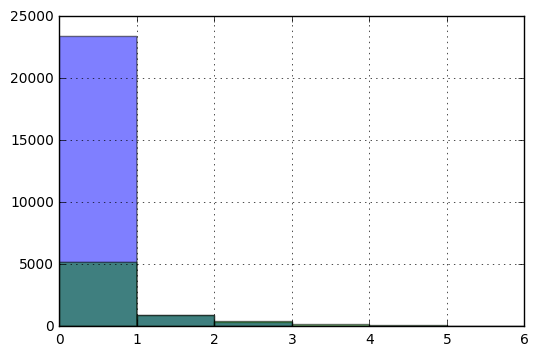

In [12]:
# compare pass rates for different violation counts
bins = np.linspace(0,6,7)
data[data.result_binary == 1].citations_count.hist(normed=False,alpha=0.5,bins=bins)
data[data.result_binary == 0].citations_count.hist(normed=False,alpha=0.5,bins=bins)

In [13]:
def prev_inspection_features(data,inspection_id,date):
    current_inspection = data.ix[data[data.inspection_id==inspection_id].index[0]]
    
    all_inspections = data[data.license_ == current_inspection.license_]
    
    previous_inspections = all_inspections[all_inspections.inspection_date < date]
    if len(previous_inspections) >= 1:
        last_inspection_index = previous_inspections.inspection_date.sort_values().index[-1]
        fraction = previous_inspections.result_binary.mean()
        count = previous_inspections.result_binary.count()
        last = previous_inspections.result_binary[last_inspection_index]
        
        if type(pd.to_datetime('nan')) != type(current_inspection.license_start_date):
            license_age = current_inspection.inspection_date - current_inspection.license_start_date
            license_age = license_age.days
            if license_age <= 0:
                license_age = 0
        else:
            license_age = float('nan')
            
        time_since_last = current_inspection.inspection_date - previous_inspections.ix[last_inspection_index].inspection_date
        time_since_last = time_since_last.days
        
        prev_violations = previous_inspections.violations_count[last_inspection_index]
        prev_citations = previous_inspections.citations_count[last_inspection_index]
        prev_critical = previous_inspections.critical_count[last_inspection_index]
        prev_serious = previous_inspections.serious_count[last_inspection_index]
        prev_minor = previous_inspections.minor_count[last_inspection_index]
        
        
        
    else:
        fraction = float('nan')
        count = 0
        last = float('nan')
        license_age = float('nan')
        time_since_last = float('nan')
        prev_violations = float('nan')
        prev_citations = float('nan')
        prev_critical = float('nan')
        prev_serious = float('nan')
        prev_minor = float('nan')
        
        
        
        
    return np.array([count,
                     fraction,
                     last,
                     license_age,
                     time_since_last,
                     prev_violations,
                     prev_citations,
                     prev_critical,
                     prev_serious,
                     prev_minor])
    
    


In [14]:
previous_inspection_features = np.zeros((len(data.index),10))


LOG_EVERY_N = 10000
for index in data.index:
    previous_inspection_features[index,:] = prev_inspection_features(data,data.ix[index].inspection_id,data.ix[index].inspection_date)
    if (index % LOG_EVERY_N) == 0:
        print index


0
10000
20000
30000


In [15]:
data['previous_count'] = previous_inspection_features[:,0]
data['previous_fraction'] = previous_inspection_features[:,1]
data['previous_result'] = previous_inspection_features[:,2]
data['license_age'] = previous_inspection_features[:,3]
data['time_since_last_inspection'] = previous_inspection_features[:,4]
data['previous_violations'] = previous_inspection_features[:,5]
data['previous_citations'] = previous_inspection_features[:,6]
data['previous_critical'] = previous_inspection_features[:,7]
data['previous_serious'] = previous_inspection_features[:,8]
data['previous_minor'] = previous_inspection_features[:,9]



In [16]:
for col in data.columns:
    print col

dba_name
facility_type
inspection_date
inspection_type
inspection_id
violations
latitude
license_
longitude
results
risk
zip
business_activity
date_issued
latitude_biz
license_description
license_start_date
license_status
longitude_biz
police_district
precinct
site_number
ward_precinct
zip_code
creation_date
num_sanitation_in_police_dist
sanit_count
crime_count
index
district
crime_count_by_district
date
result_binary
consumption_license
tobacco
grocery
violations_count
citations_count
critical_count
serious_count
minor_count
previous_count
previous_fraction
previous_result
license_age
time_since_last_inspection
previous_violations
previous_citations
previous_critical
previous_serious
previous_minor


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide


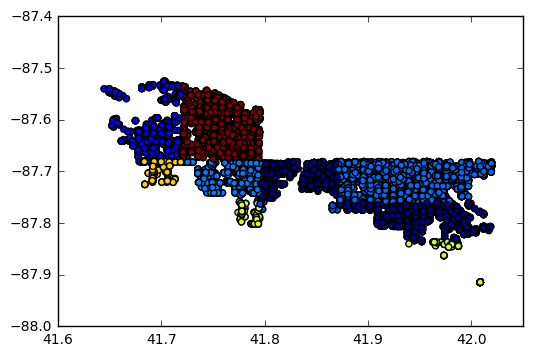

[  1.00000000e+00   2.28000000e+02   6.20000000e+01   1.39100000e+03
   3.31000000e+02   6.41000000e+02   2.58000000e+02   1.18520000e+04
   3.55400000e+03   1.30100000e+03   1.30000000e+03   3.81000000e+03
   3.56500000e+03   3.38900000e+03   1.18800000e+03   2.18400000e+03
   2.39500000e+03   3.58000000e+02   8.41000000e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.09649123  0.11290323  0.12724659  0.12990937  0.16536661
  0.16666667  0.17296659  0.1736072   0.17601845  0.18        0.18530184
  0.18737728  0.18825612  0.20959596  0.21108059  0.21544885  0.23463687
  0.24851367         nan         nan         nan         nan         nan
         nan]


In [17]:

#adjust number of buckets using np.linspace ----------------->
yedges = np.linspace(data.longitude.min(),data.longitude.max(),6)
xedges = np.linspace(data.latitude.min(),data.latitude.max(),6)

x = np.array(data.latitude)
y = np.array(data.longitude)

x1 = np.array(data[data.result_binary == 1].latitude)
y1 = np.array(data[data.result_binary == 1].longitude)

x0 = np.array(data[data.result_binary == 0].latitude)
y0 = np.array(data[data.result_binary == 0].longitude)


hist0, xedges, yedges = np.histogram2d(x0, y0, (xedges, yedges))
hist1, xedges, yedges = np.histogram2d(x1, y1, (xedges, yedges))

hist = hist0/(hist1+hist0)
hist_count = hist1+hist0

xidx = np.clip(np.digitize(x, xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(y, yedges), 0, hist.shape[1]-1)

c = hist[xidx, yidx]
plt.scatter(x, y, c=c)

plt.show()

sorted_index = np.argsort(hist.reshape(1,-1))

print hist_count.reshape(1,-1)[0][sorted_index[0]]
print hist.reshape(1,-1)[0][sorted_index[0]]

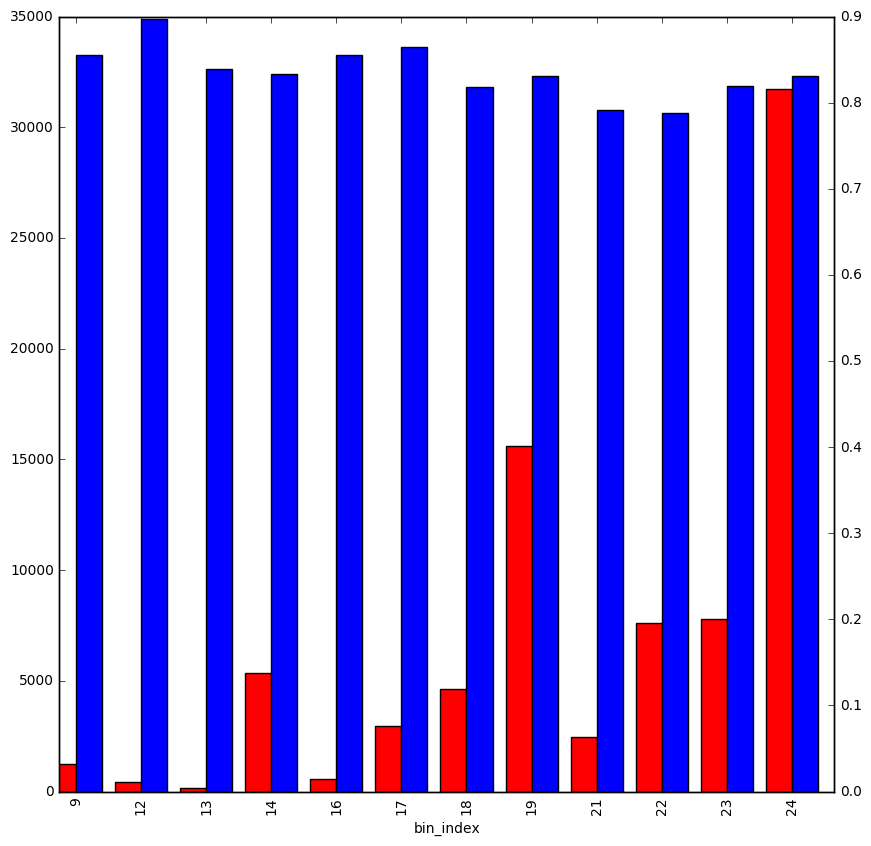

In [45]:
data['bin_index'] = hist.shape[1]*yidx + xidx

fig = plt.figure(figsize=(10,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4


data.groupby('bin_index').count().result_binary.plot(kind='bar', color='red', ax=ax, width=width, position=1)
data.groupby('bin_index').mean().result_binary.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)


plt.show()

In [46]:
result_index = data.groupby('license_description').mean().result_binary.sort_values().index
data.groupby('license_description').mean().result_binary.sort_values()[result_index]

license_description
Tobacco Vending, Individual                            0.571429
Scavenger, Private                                     0.666667
Music and Dance                                        0.666667
Late Hour                                              0.666667
Tire Facilty Class I (100 - 1,000 Tires)               0.666667
Filling Station                                        0.666667
Mobile Food License                                    0.703488
Tavern                                                 0.739612
Night Care Privilege                                   0.750000
Hazardous Materials                                    0.756098
Consumption on Premises - Incidental Activity          0.766180
Public Garage                                          0.777778
Package Goods                                          0.781659
Wholesale Food Establishment                           0.784314
Special Event Food                                     0.790698
Limited Business Lic

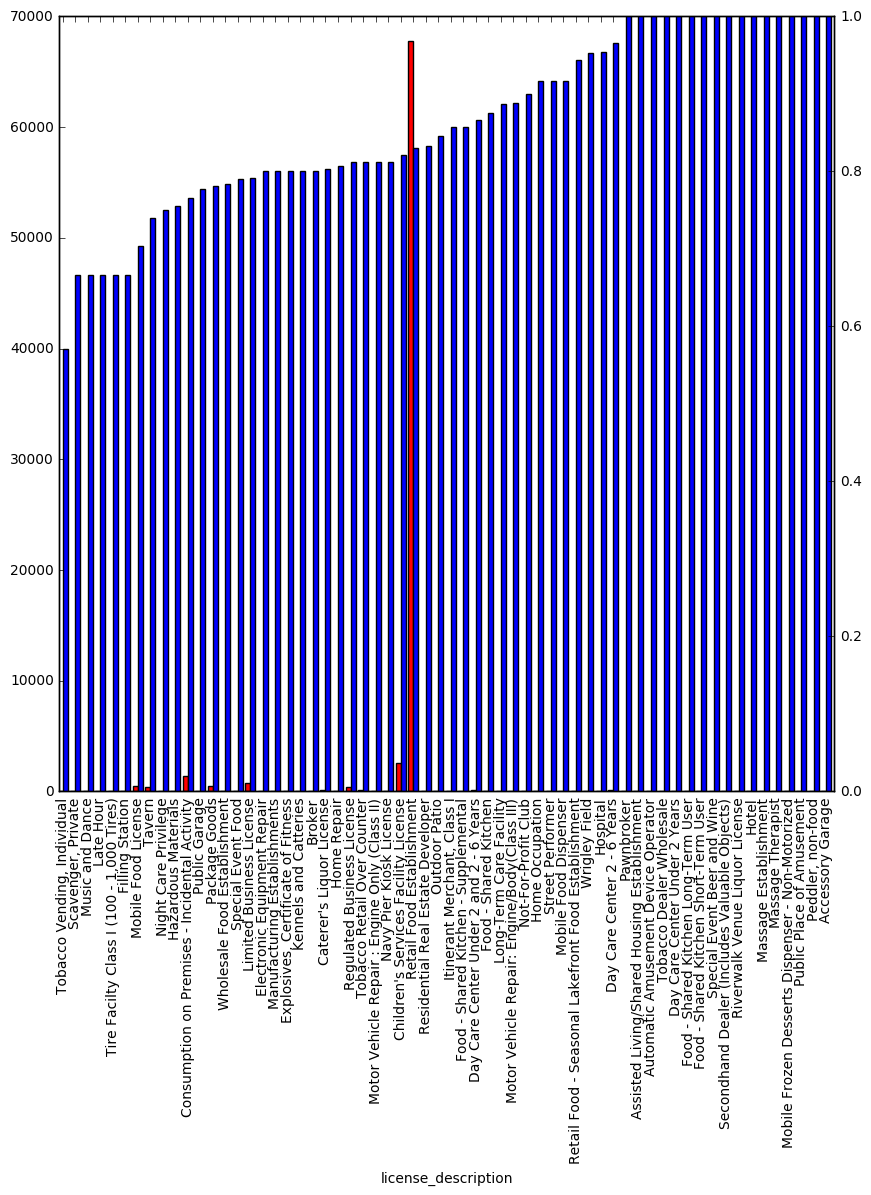

In [47]:

fig = plt.figure(figsize=(10,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4


data.groupby('license_description').count().result_binary[result_index].plot(kind='bar', color='red', ax=ax, width=width, position=1)
data.groupby('license_description').mean().result_binary.sort_values()[result_index].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)


plt.show()



In [48]:
top_50 = data.groupby('facility_type').count().result_binary.sort_values().index[-50:]

In [49]:
data.groupby('facility_type').mean().result_binary[top_50].sort_values()

top_50count_mean_sorted_index = data.groupby('facility_type').mean().result_binary[top_50].sort_values().index



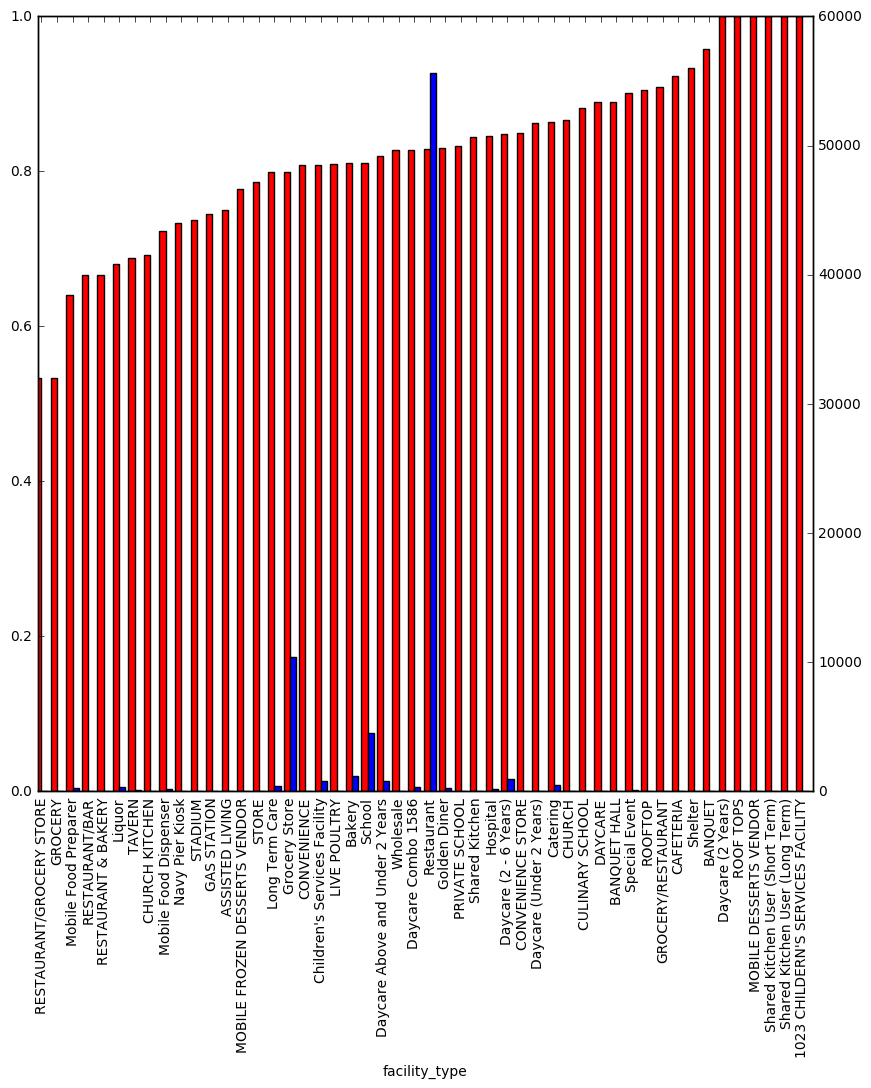

In [50]:

fig = plt.figure(figsize=(10,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4


data.groupby('facility_type').mean().result_binary[top_50].sort_values().plot(kind='bar', color='red', ax=ax, width=width, position=1)
data.groupby('facility_type').count().result_binary[top_50count_mean_sorted_index].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)


plt.show()


#### Baseline modeling

In [52]:
# Simple averaging

simple_avg_classifier = []

for frac in data.previous_fraction:
    if frac > 0.5:
        simple_avg_classifier.append(1)
    elif frac < 0.5:
        simple_avg_classifier.append(1)
    
    else:
        simple_avg_classifier.append(np.random.choice([0,1]))
        
print np.mean(np.array(simple_avg_classifier) == data.result_binary)

0.711330991074


In [135]:
cols = ['results', 
        'result_binary', 
        'risk', 
        'sanit_count', 
        'crime_count', 
        'consumption_license', 
        'tobacco', 
        'grocery', 
        'previous_count',
        'minor_count',
        'previous_fraction', 
        'previous_result', 
        'license_age', 
        'time_since_last_inspection', 
        'previous_violations', 
        'previous_citations', 
        'previous_critical', 
        'previous_serious', 
        'previous_minor', 
        'bin_index']

print data[cols].shape
print data.shape

# select specific features
data_sub = data[cols]
# drop NaN
data_sub = data_sub.dropna(axis=0)

(80549, 20)
(80549, 52)


In [150]:
# check response
print 'Useless response count:', sum((data_sub.results != 'Pass') & (data_sub.results != 'Pass w/ Conditions') & (data_sub.results != 'Fail'))
indices = (data_sub.results == 'Pass') | (data_sub.results == 'Pass w/ Conditions') | (data_sub.results == 'Fail')
data_sub = data_sub[indices]

Useless response count: 0


In [137]:
# response
y2 = data_sub.result_binary
y3 = data_sub.results
# features
x = data_sub.drop(['result_binary', 'results'], axis = 1) 

# print data_sub.shape, data_sub_x.shape, data_sub_y_2, data_sub_y_3

In [138]:
# encode
x_encoded = pd.DataFrame({})
for column in x.columns:
    if (x[column].unique().shape[0] < 8) or x[column].dtype == np.dtype('object'):
        encoding = pd.get_dummies(x[column])
        x_encoded = pd.concat([x_encoded, encoding], axis = 1)
    else:
        x_encoded = pd.concat([x_encoded, x[[column]].astype(float)], axis = 1)

In [139]:
from sklearn import linear_model

baseline = linear_model.LogisticRegression()
baseline.fit(x_encoded, y2)
print baseline.score(x_encoded, y2)

baseline = linear_model.LogisticRegression(solver='newton-cg', multi_class = 'multinomial')
baseline.fit(x_encoded, y3)
print baseline.score(x_encoded, y3)

0.854194344278
0.719562535586


In [149]:
# arbitary split
from sklearn.cross_validation import train_test_split as sk_split
test_size = 0.20
x_train, x_test, y2_train, y2_test = sk_split(x_encoded, y2, test_size = test_size)

baseline = linear_model.LogisticRegression()
baseline.fit(x_train, y2_train)
print 'Score:', baseline.score(x_test, y2_test)
print 'Score for passing inspections:', baseline.score(x_train[y2_train == 1], y2_train[y2_train == 1])
print 'Score for non-passing inspections:', baseline.score(x_train[y2_train == 0], y2_train[y2_train == 0])

Score: 0.856719250385
Score for passing inspections: 0.992206562511
Score for non-passing inspections: 0.247205365698


In [146]:
# class counts in training set

print 'Count did not pass:', sum(y2_train == 0)
print 'Count did pass:', sum(y2_train == 1)

Count did not pass: 6235
Count did pass: 27486


In [143]:
# quick fix for imbalance

# takes x_train, y_train and returns a class-balanced x_train, y_train 
# assumes count of class 0 > count of class 1
def subsample(x_train, y_train):
    train = pd.concat([x_train, y_train], axis = 1)

    train_0 = train[y_train == 0]
    train_1 = train[y_train == 1]
    
    train_1_subsample = train_1.sample(train_0.shape[0])
    
    train_subsample = pd.concat([train_1_subsample, train_0], axis = 0)
    
    x_train_subsample = train_subsample.iloc[:, :-1]
    y_train_subsample = train_subsample.iloc[:, -1]
    
    return x_train_subsample, y_train_subsample
    
## test subsampling algorithm with same simple classifier
x_train_sub, y2_train_sub = subsample(x_train, y2_train)

print x_train_sub.shape
print y2_train_sub.shape


(12470, 24)
(12470,)


In [148]:
baseline_cls_corr = linear_model.LogisticRegression()
baseline_cls_corr.fit(x_train_sub, y2_train_sub)
print 'Score:', baseline_cls_corr.score(x_test, y2_test)
print 'Score for passing inspections:',baseline_cls_corr.score(x_test[y2_test == 1], y2_test[y2_test == 1])
print 'Score for non-passing inspections:', baseline_cls_corr.score(x_test[y2_test == 0], y2_test[y2_test == 0])

Score: 0.713912940339
Score for passing inspections: 0.738012205754
Score for non-passing inspections: 0.606843124597
